## Pre-requisites
This block makes the necessary installations and imports for the rest of the code blocks to run, connects to the GPU if one is available, and specifies the location of the folder containing the data. That data folder should contain a sub-folder containing all nifti files, along with a metadata csv file.

In [29]:
!pip install torch torchvision
!pip install opencv-contrib-python
!pip install scikit-learn
!pip install SimpleITK
!pip install Kornia
!pip install albumentations
!pip install torchio

import numpy as np
import random
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torch
import kornia.augmentation as K
import albumentations as A
import torchio as tio

from mpl_toolkits.mplot3d import Axes3D
from torch.nn import Module
from torch.nn import Conv3d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch.optim import Adam
import torchvision.models as models
from torch.autograd import Variable
from kornia.augmentation import ColorJitter, RandomChannelShuffle, RandomHorizontalFlip, RandomThinPlateSpline

# Connect to GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# Specify project folder location
project_folder = "/content/drive/MyDrive/Data/"

     |████████████████████████████████| 164 kB 5.4 MB/s 
Using cuda device


## Define arrays of patient and outcome data
This block allows you to specify the criteria which defines the patient outcome as True or False. It then loops through all the patients in the metadata.csv file, searches for their corresponding image in the image folder, and then adds patient and outcome to either the training, testing, or validation array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Open the metadata.csv file, convert to an array, and remove column headers
metadata_file = open(project_folder + "metadata.csv")
metadata = np.loadtxt(metadata_file, dtype="str", delimiter=",")
metadata = metadata[1:][:]

# outcome_type = int(input("Select which outcome you are aiming to predict \n(1=Locoregional, 2=Distant Metastasis, 3=Death):"))
# check_day = int(input("Select the number of days at which to check for event:"))
# outcomes_train = []
# outcomes_test = []
# images = []

# for patient in metadata:
#   if (patient[(5+outcome_type)] == "") and (int(patient[5]) >= check_day):
#     # Last follow up after check day, no event
#     outcome = 0
#   elif (patient[(5+outcome_type)] == "") and (int(patient[5]) < check_day):
#     # Last follow up before check day, event unknown
#     continue
#   elif int(patient[(5+outcome_type)]) <= check_day:
#     # Event occurred before or on check day
#     outcome = 1
#   else:
#     # Event occurred after check day
#     outcome = 0
#   if not os.path.exists(project_folder + "crop/" + patient[0] + ".nii"):
#     print("No image found for patient " + patient[0])
#     continue
  

#   # Add patient name, outcome and image to array
#   if random.randint(0,1)==0:
#     outcomes_train.append([patient[0], outcome])
#   else:
#     outcomes_test.append([patient[0], outcome])


# print(outcomes_train, outcomes_test)



outcome_type = 3 #int(input("Select which outcome you are aiming to predict \n(1=Locoregional, 2=Distant Metastasis, 3=Death):"))
check_day = 500 #int(input("Select the number of days at which to check for event:"))
which_patients = 0 #int(input("Do you want to include patients whose last follow up is before the check day? (no = 0, yes = 1):"))
patient_with_event = []
patient_no_event = []
outcomes_train = []
outcomes_test = []
images = []

for patient in metadata:
  if (patient[(5+outcome_type)] == "") and (int(patient[5]) >= check_day):
    # Last follow up after check day, no event
    outcome = 0
  elif (patient[(5+outcome_type)] == "") and (int(patient[5]) < check_day) and (which_patients == 0):
    # Last follow up before check day, event unknown
    continue
  elif (patient[(5+outcome_type)] == "") and (int(patient[5]) < check_day) and (which_patients == 1):
    outcome = 0
  elif int(patient[(5+outcome_type)]) <= check_day:
    # Event occurred before or on check day
    outcome = 1
  else:
    # Event occurred after check day
    outcome = 0
  if not os.path.exists(project_folder + "crop/" + patient[0] + ".nii"):
    print("No image found for patient " + patient[0])
    continue
  
  if outcome == 1:
    patient_with_event.append([patient[0], outcome])
  else:
    patient_no_event.append([patient[0], outcome])

# Make arrays the same length
if len(patient_with_event) < len(patient_no_event):
  new_patient_no_event = random.sample(patient_no_event,len(patient_with_event))
  new_patient_with_event = patient_with_event
  #print(len(new_patient_no_event))
elif len(patient_with_event) > len(patient_no_event):
  new_patient_with_event = random.sample(patient_with_event, len(patient_no_event))
  new_patient_no_event = patient_no_event
elif len(patient_with_event) == len(patient_no_event):
  new_patient_no_event = patient_no_event
  new_patient_with_event = patient_with_event

# Add patient name, outcome and image to array
seventy_percent_event = int(0.7*len(new_patient_with_event))
seventy_percent_no_event = int(0.7*len(new_patient_no_event))

train_patients_event = random.sample(new_patient_with_event, seventy_percent_event)
train_patients_no_event = random.sample(new_patient_no_event, seventy_percent_no_event)

def remove(small_array, original_array):
  for i in small_array:
    original_array.remove(i)
    
  return original_array

new_patients_with_event = remove(train_patients_event, new_patient_with_event)
new_patient_no_event = remove(train_patients_no_event, new_patient_no_event)

fifty_percent_event = int(0.5*len(new_patient_with_event))
fifty_percent_no_event = int(0.5*len(new_patient_no_event))

validate_patients_event = random.sample(new_patient_with_event, fifty_percent_event)
validate_patients_no_event = random.sample(new_patient_no_event, fifty_percent_event)

new_patients_with_event = remove(validate_patients_event, new_patient_with_event)
new_patient_no_event = remove(validate_patients_no_event, new_patient_no_event)

test_patients_event = new_patient_with_event
test_patients_no_event = new_patient_no_event

# print(train_patients_event)
# print(train_patients_no_event)
# print(validate_patients_event)
# print(validate_patients_no_event)
# print(test_patients_event)
# print(test_patients_no_event)


outcomes_train = train_patients_event + train_patients_no_event
outcomes_validate = validate_patients_event + validate_patients_no_event
outcomes_test = test_patients_event + test_patients_no_event

print(outcomes_train)
print(outcomes_validate)
print(outcomes_test)

No image found for patient HN-CHUM-005
No image found for patient HN-CHUM-016
No image found for patient HN-CHUM-040
No image found for patient HN-CHUM-051
No image found for patient HN-CHUS-033
No image found for patient HN-CHUS-086
No image found for patient HN-CHUS-089
No image found for patient HN-CHUS-093
No image found for patient HN-CHUS-096
No image found for patient HN-CHUS-099
No image found for patient HN-HGJ-003
No image found for patient HN-HGJ-008
No image found for patient HN-HGJ-010
No image found for patient HN-HGJ-028
No image found for patient HN-HGJ-034
No image found for patient HN-HGJ-038
No image found for patient HN-HGJ-041
No image found for patient HN-HGJ-046
No image found for patient HN-HGJ-047
No image found for patient HN-HGJ-048
No image found for patient HN-HGJ-054
No image found for patient HN-HGJ-055
No image found for patient HN-HGJ-056
No image found for patient HN-HGJ-063
No image found for patient HN-HGJ-064
No image found for patient HN-HGJ-065
No

## Augmentation

In [ ]:
# class kornia.augmentation.RandomAffine(degrees, translate=None, scale=None, 
#                                        shear=None, resample=Resample.BILINEAR.name,
#                                        return_transform=False, same_on_batch=False, 
#                                        align_corners=False, padding_mode=SamplePadding.ZEROS.name, 
#                                        p=0.5, keepdim=False)

#rotation_transform = transforms.RandomAffine((-5., 5.), return_transform=True, p=0.2)

train_transform = A.Compose(
    [
        #A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0, scale_limit=1, rotate_limit=5, p=0.5),
        #A.ShiftScaleRotate(shift_limit=0, scale_limit=0.05, rotate_limit=5, p=0.5)
        #A.RandomCrop(height=128, width=128),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #ToTensorV2(),
    ]
)
def transform_for_train(fixed_scale = 512, rotate_prob = 5):
    """
    Options:
    1.RandomCrop
    2.CenterCrop
    3.RandomHorizontalFlip
    4.Normalize
    5.ToTensor
    6.FixedResize
    7.RandomRotate
    """
    transform_list = [] 
    #transform_list.append(FixedResize(size = (fixed_scale, fixed_scale)))
    #transform_list.append(RandomSized(fixed_scale))
    transform_list.append(transforms.RandomRotation(rotate_prob))
    transform_list.append(transforms.RandomHorizontalFlip())
    #transform_list.append(transforms.RandomAffine3D(scale = 0.9))
    #transform_list.append(Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    
    #transform_list.append(Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)))
    transform_list.append(transforms.ToTensor())

    #return transforms.Compose(transform_list) 
    return transform_list

#train_transform_list = transform_for_train()
#print(train_transform_list)

## Define dataset class
This block defines the class on which to build dataset objects

In [ ]:
import os
from torchvision.io import read_image

class ImageDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=transforms.ToTensor(), target_transform=None):
        self.img_labels = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx][0]+".nii")
        image_sitk = sitk.ReadImage(img_path)
        image = sitk.GetArrayFromImage(image_sitk)
        label = self.img_labels[idx][1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Build Datasets
This block uses the class and arrays defined previously to build datasets for training, testing and validation.

In [32]:
# multi_transform = nn.Sequential(
#             K.RandomHorizontalFlip3D(p=0.75),
#             #K.RandomAffine(5),
#             #K.RandomRotation3D((15., 20., 20.), p=1.0, return_transform=True)
#         )
# multi_transform = torch.nn.Sequential(
#     transforms.ToTensor(),
#     transforms.RandomRotation(5,fill=0),
#     transforms.RandomHorizontalFlip()
# )

# multi_transform = transforms.Compose([
#     transforms.ToTensor(), 
#     transforms.RandomApply([
#          #transforms.RandomApply([transforms.RandomRotation(90)], 1),
#          #transforms.RandomApply([transforms.RandomAffine(90, fill=0)], 1),
#          #transforms.RandomApply([transforms.RandomAffine(0, scale=[1,1])], 1),
#          #transforms.RandomApply([transforms.RandomHorizontalFlip()], 0)
#         ], p= 1)
# ])

mult_transform = (
    tio.RandomFlip(axes=('LR',), flip_probability=1),
    tio.RandomAffine(degrees=90),
    tio.RandomAffine(scales = (1,1,1))
)

training_data = ImageDataset(outcomes_train, project_folder + "crop/", transform = multi_transform)
validation_data = ImageDataset(outcomes_validate, project_folder + "crop/")
test_data = ImageDataset(outcomes_test, project_folder + "crop/")

## View binary masks in 3d
This block allows you to view a binary mask from the image in 3d by extracting the image from a given dataset. This helps to confirm that the data has not been affected by reading in to pytorch.

ValueError: ignored

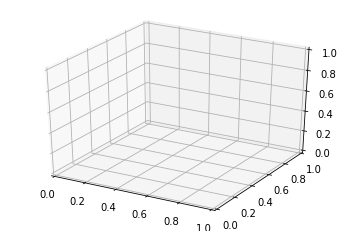

In [33]:
# Set which dataset to look at, and the index of the patient to view
dataset = training_data
index = 2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

array = dataset[index][0].numpy()
x,y,z = np.where(array > -1024)
ax.scatter(x, y, z, c=z, alpha=1)

ax.set_xlim(0,246)
ax.set_ylim(0,246)
ax.set_zlim(0,246)


# Dataloader

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=4, shuffle=True)

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.cnn_layers = nn.Sequential(
      # Layer 1
      nn.Conv3d(1,1,4,1,1),
      nn.BatchNorm3d(4),
      nn.ReLU(inplace=True),
      # Layer 2
      nn.Conv3d(1, 1, 4, 1, 1),
      nn.BatchNorm3d(4),
      nn.ReLU(inplace=True),
      nn.MaxPool3d(kernel_size=2, stride=2),
    )
    self.linear_layers = nn.Sequential(
      nn.Linear(4 * 7 * 7, 10)
    )
  def __forward__(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x

model = CNN().to(device)
print(model)


CNN(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 1, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(1, 1, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [ ]:
# defining the model
model = CNN()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
model.to(device)
criterion.to(device)
    
print(model)

CNN(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 1, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(1, 1, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [ ]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    train = train_dataloader
    # getting the validation set
    val = validation_dataloader
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [ ]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

NameError: ignored

## Archive

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
learning_rate = 0.001

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


NotImplementedError: ignored

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(246*246, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512, 2),
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits